### Import Library

In [1]:
import os
import pandas as pd
import torch
from argparse import Namespace
from torch.utils.data import DataLoader
from MLPpatchLatentV3 import Model

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from config.KR_3 import *
from model.dfm_model import * 
from model.var_model import *
from model.kalman_filter import *
from utils.deep_learning import *
from utils.data_loader import *
from utils.visualization import *

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Load Data

In [2]:
target_df = load_target_data(TARGET_PATH)
target_df_train = target_df[target_df.index < TEST_DATE]
target_df_test  = target_df[target_df.index >= TEST_DATE]

### Dynamic Factor Model (DFM)

In [3]:
dfm_results = run_dfm(target_df_train, target_df_test, REFERENCE_DATE, 5)
# train phase 
optimal_factors = dfm_results["optimal_factors"]
shared_component_final_train = dfm_results["shared_component_final_train"]
loadings     = dfm_results["loadings"]
scale_factor = dfm_results["scale_factor"]
offset       = dfm_results["offset"]

combined_array = dfm_results["combined_shared_component"]

factor_column_list = []
for i in range(optimal_factors):
    factor_column_list.append("factor"+str(i+1))

factor_df = pd.DataFrame(combined_array, columns=factor_column_list, index=target_df.index)


Optimization terminated successfully.
         Current function value: 18.458637
         Iterations: 17
         Function evaluations: 9882


In [4]:
df = load_feature_data(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)
df = pd.concat([df, factor_df], axis=1)
df = df.dropna()

In [5]:
# First-order difference
data_diff = df.diff().dropna()
# Select explanatory variables using Granger test (excluding target)
granger_values = granger_test(data_diff[data_diff.index < TEST_DATE], "factor1", maxlag=23)

{'call_rate': 8, 'bond_3yr': 23, 'loan_rate_avg': 23, 'KOSPI': 9, 'NASDAQ': 9, 'M2_KR': 12, 'M2_US': 12, 'broad_liquidity': 19, 'CPI_growth': 23, 'USD_KRW_rate': 8, 'GDP_growth': 21, 'res_start': 2, 'res_permit': 4, 'factor2': 12}


In [6]:
granger_test_all(data_diff[data_diff.index < TEST_DATE], "factor1", maxlag=23)

{'call_rate': {8: 0.038773424158661966},
 'bond_3yr': {5: 0.03827589829865135,
  6: 0.04447169776819356,
  7: 0.03773129012789995,
  8: 0.017355579011233642,
  9: 0.012619006358335677,
  10: 0.025810179102971974,
  18: 0.038058128951062725,
  19: 0.04764539190741752,
  20: 0.02630061970136447,
  21: 0.04424475382498023,
  22: 0.013292012238407582,
  23: 0.012127716141507629},
 'loan_rate_avg': {11: 0.04019720959851387,
  12: 0.021532471261044316,
  13: 0.04705201210176271,
  14: 0.040647899536805636,
  17: 0.048297609568081434,
  22: 0.0288088222930966,
  23: 0.016945523192330104},
 'KOSPI': {5: 0.026327338050742246,
  6: 0.04737892569698079,
  7: 0.02638850968868621,
  8: 0.003921017525323198,
  9: 0.003610337569532861,
  10: 0.009009303424035262,
  11: 0.02024729374134434,
  23: 0.005035314599594481},
 'NASDAQ': {5: 0.008317912838716583,
  6: 0.012470184733427182,
  7: 0.03872106146742732,
  8: 0.023165337741172378,
  9: 0.005052912052065585,
  10: 0.011947032451388777,
  11: 0.03083

In [7]:
data = data_diff[data_diff.index < TEST_DATE]
target = "factor2"
maxlag=23
granger_values = {}
significant_results = {}
for col in data.columns:
    if col != target:
        test_result = grangercausalitytests(data[[target, col]], maxlag=maxlag, verbose=False)
        sig_lags = {}
        
        for lag, result in test_result.items():
            f = result[0]['ssr_chi2test'][0]
            p_value = result[0]['ssr_chi2test'][1]
            if p_value <= 0.05:
                sig_lags[lag] = [round(f,3), round(p_value,3)]
        if sig_lags:
            significant_results[col] = sig_lags
granger_values[target] = significant_results
print(significant_results)

{'call_rate': {1: [6.488, 0.011], 3: [9.911, 0.019], 4: [10.798, 0.029], 5: [12.64, 0.027], 6: [13.952, 0.03], 7: [14.757, 0.039], 8: [23.035, 0.003], 9: [31.802, 0.0], 10: [33.368, 0.0], 11: [33.155, 0.0], 12: [33.743, 0.001], 13: [37.232, 0.0], 14: [35.849, 0.001], 15: [44.582, 0.0], 16: [48.566, 0.0], 17: [52.375, 0.0], 18: [54.46, 0.0], 19: [56.025, 0.0], 20: [64.956, 0.0], 21: [65.709, 0.0], 22: [66.687, 0.0], 23: [66.514, 0.0]}, 'bond_3yr': {1: [19.42, 0.0], 2: [16.476, 0.0], 3: [20.949, 0.0], 4: [27.271, 0.0], 5: [32.657, 0.0], 6: [33.85, 0.0], 7: [32.128, 0.0], 8: [31.397, 0.0], 9: [34.164, 0.0], 10: [34.064, 0.0], 11: [35.736, 0.0], 12: [40.797, 0.0], 13: [44.297, 0.0], 14: [45.865, 0.0], 15: [47.327, 0.0], 16: [49.199, 0.0], 17: [69.458, 0.0], 18: [70.353, 0.0], 19: [72.238, 0.0], 20: [69.49, 0.0], 21: [72.635, 0.0], 22: [76.706, 0.0], 23: [87.693, 0.0]}, 'loan_rate_avg': {1: [15.38, 0.0], 2: [6.366, 0.041], 3: [8.613, 0.035], 9: [21.866, 0.009], 10: [24.679, 0.006], 11: [24.

### Vector Autoregression (VAR)

{'call_rate': 8, 'bond_3yr': 23, 'loan_rate_avg': 23, 'KOSPI': 9, 'NASDAQ': 9, 'M2_KR': 12, 'M2_US': 12, 'broad_liquidity': 19, 'CPI_growth': 23, 'USD_KRW_rate': 8, 'GDP_growth': 21, 'res_start': 2, 'res_permit': 4, 'factor2': 12}


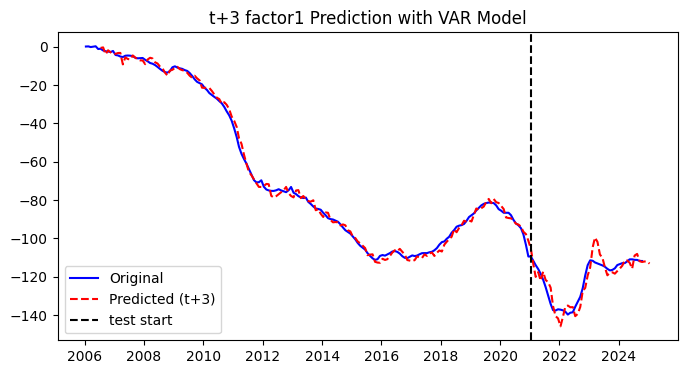

{'call_rate': 20, 'bond_3yr': 23, 'loan_rate_avg': 22, 'KOSPI': 22, 'KOSDAQ': 22, 'NASDAQ': 23, 'M2_KR': 23, 'M2_US': 18, 'broad_liquidity': 23, 'USD_KRW_rate': 22, 'GDP_growth': 23, 'res_permit': 20}


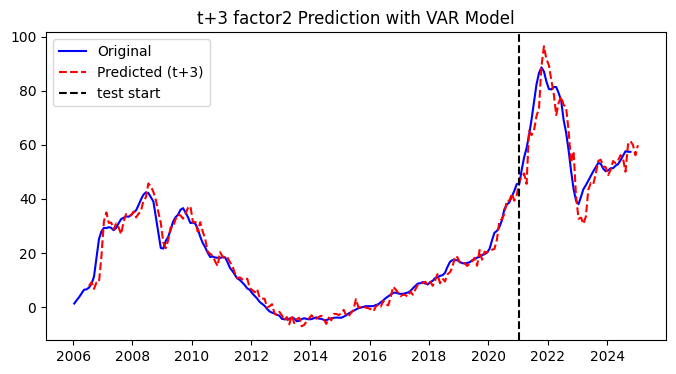

In [8]:
forecast_dfs = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    
    forecast_dfs[factor_name] = var_forecast(df, factor_name, TEST_DATE, MAXLAG_FACTOR, SELECTED_LAG_FACTOR, FORECAST_HORIZON)
    
    plot_var_forecast(df, forecast_dfs[factor_name], factor_name, TEST_DATE, FORECAST_HORIZON)

### Kalman Filter

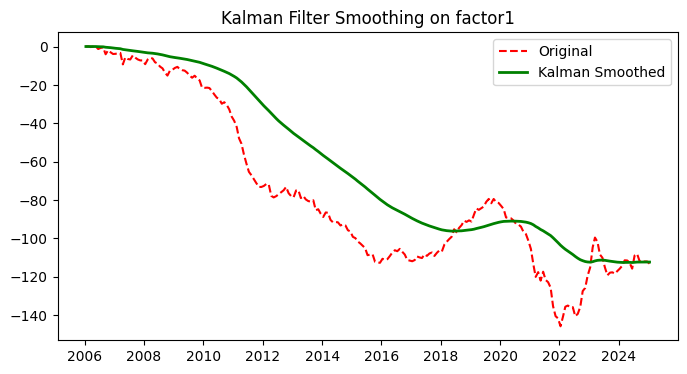

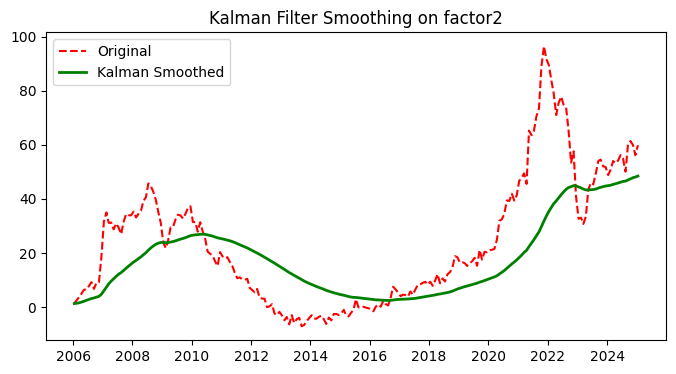

In [9]:
smoothed_factors = {} 
c=["#FF8383", "#5DB996"]
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    combined_series = pd.concat([df[factor_name][TRAIN_DATE:TRAIN_DATE[:6]+str(FORECAST_HORIZON+SELECTED_LAG_FACTOR)+'-15'], forecast_dfs[factor_name][factor_name]])
    smoothed = apply_kalman_filter(combined_series, KALMAN_OBSERVATION_COV, KALMAN_TRANSITION_COV)
    plot_kalman_filter_result(combined_series, smoothed, factor_name)
    smoothed_factors[factor_name] = smoothed


### Deep Residual Learning

In [10]:
smoothed_factors_df = pd.concat(list(smoothed_factors.values()), axis=1)
smoothed_factors_df.columns = [f"factor{i+1}" for i in range(optimal_factors)]

common_index = target_df.index.intersection(smoothed_factors_df.index)
smoothed_factors_df = smoothed_factors_df.loc[common_index]
target_df_common = target_df.loc[common_index]

target_mean = target_df_train.mean().values
factors_adjusted = (smoothed_factors_df.values @ loadings.T) * scale_factor + target_mean + offset

resid = target_df_common - factors_adjusted
resid = resid.reset_index().rename(columns={"index": "Date"})
resid["Date"] = pd.to_datetime(resid["Date"])

⭐️ Calculate Distance Matrix

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, wasserstein_distance
from sklearn.preprocessing import MinMaxScaler

# 샘플 데이터 (실제 데이터로 대체하세요)
# original_train, original_test, ice_train, ice_test = ...

def cohen_d(x, y):
    # x와 y는 두 데이터셋
    diff_mean = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt(((len(x) - 1) * np.std(x, ddof=1) ** 2 + (len(y) - 1) * np.std(y, ddof=1) ** 2) / (len(x) + len(y) - 2))
    return diff_mean / pooled_std

# 히스토그램 기반 확률분포로 변환
def to_prob_dist(arr, bins=100):
    hist, bin_edges = np.histogram(arr, bins=bins, range=(np.min(arr), np.max(arr)), density=True)
    # 0 값 방지 → 작은 값 추가 (for KL)
    hist += 1e-10
    return hist / hist.sum()

# 분포 거리 계산 함수
def compute_metrics(p, q):
    jsd = jensenshannon(p, q)
    kl = entropy(p, q)  # KL(p||q)
    wass = wasserstein_distance(p, q)
    return jsd, wass, kl

# 각 데이터에 대해 분포 변환
for col in target_df.columns: 
    
    orig_train_dist = to_prob_dist(target_df_train[col])
    orig_test_dist  = to_prob_dist(target_df_test[col])
    ice_train_dist  = to_prob_dist(resid[:180][col])
    ice_test_dist   = to_prob_dist(resid[180:][col])
    

    # 계산
    jsd_orig, wass_orig, kl_orig = compute_metrics(orig_train_dist, orig_test_dist)
    jsd_ice,  wass_ice,  kl_ice  = compute_metrics(ice_train_dist,  ice_test_dist)
    
    statistic_AB, p_value_AB = stats.ks_2samp(target_df_train[col], target_df_test[col])
    statistic_CD, p_value_CD = stats.ks_2samp(resid[:180][col], resid[180:][col])

    cohen_d_AB = cohen_d(target_df_train[col], target_df_test[col])
    cohen_d_CD = cohen_d(resid[:180][col], resid[180:][col])

    # Difference
    diff_co = cohen_d_AB - cohen_d_CD
    diff_ks = p_value_AB - p_value_CD
    diff_jsd  = jsd_orig - jsd_ice
    diff_wass = wass_orig - wass_ice
    diff_kl   = kl_orig - kl_ice

    
    # Relative Reduction (%)
    rel_co   = 100 * diff_co / cohen_d_AB
    rel_ks   = -(100 * diff_ks / p_value_AB)
    rel_jsd  = 100 * diff_jsd  / jsd_orig
    rel_wass = 100 * diff_wass / wass_orig
    rel_kl   = 100 * diff_kl   / kl_orig
    # print(col)
    print(rel_ks)
    
    # DataFrame: 방식 1 + 방식 2 통합
    df_compare = pd.DataFrame({
        'Metric': ['Jensen-Shannon Divergence', 'Wasserstein Distance', 'KL Divergence', 'KS', 'Cohen'],
        # 'Original': [jsd_orig, wass_orig, kl_orig, p_value_AB],
        # 'ICE': [jsd_ice, wass_ice, kl_ice, p_value_CD],
        # 'Decrease': [diff_jsd, diff_wass, diff_kl, diff_ks],
        'Relative Reduction (%)': [
            round(rel_jsd,3), 
            round(rel_wass,3), 
            round(rel_kl,3), 
            round(rel_ks,3),
            round(rel_co, 3)]
    })
    # print(df_compare)

1.006690059791624e+28
5.75813153632402e+40
55908747269.9267
1.4533792191972323e+24
1.2543146395819408e+16
210092343311.84106
1392921571.881686
1.5650106141312259e+41
6964756179900.002
271.30317267395094
2.8149692757000795e+21
9666857789758930.0
8.748750219107277e+37
3.0424633618206513e+34
7049.603214476719
-99.99999999999844
945074238.4477613


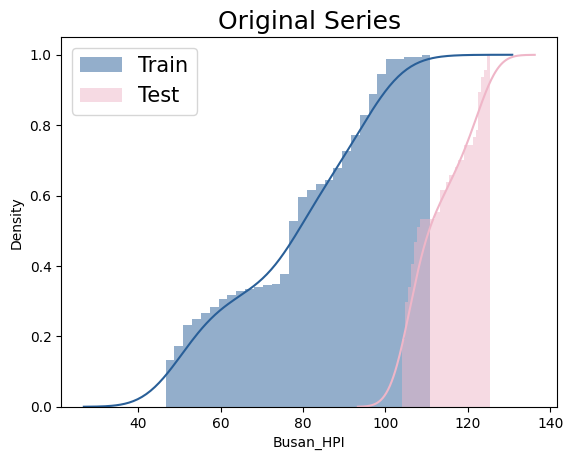

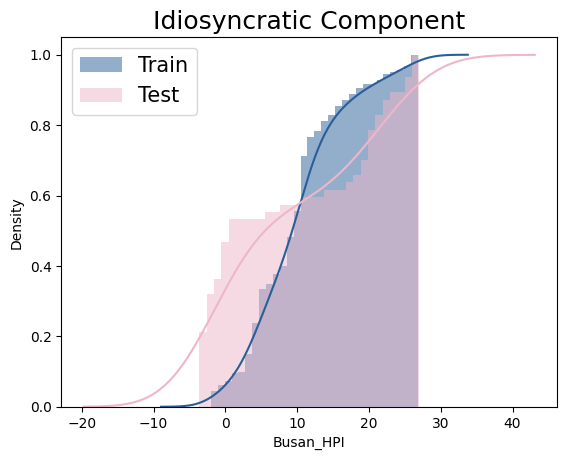

In [ ]:
import seaborn as sns
col = 'Busan_HPI'
train_color = "#295F98"
test_color = "#EFB6C8"
plt.hist(target_df_train[col], bins=30, cumulative=True, alpha=0.5, label='Train', density=True, color=train_color)
sns.kdeplot(target_df_train[col], cumulative=True, color=train_color)
plt.hist(target_df_test[col], bins=30, cumulative=True, alpha=0.5, label='Test', density=True, color=test_color)
sns.kdeplot(target_df_test[col], cumulative=True, color=test_color)
plt.legend(fontsize=15)
plt.title("Original Series", fontsize = 18)
plt.show()

plt.hist(resid[:180][col], bins=30, cumulative=True, alpha=0.5, label='Train', density=True, color=train_color)
sns.kdeplot(resid[:180][col], cumulative=True, color=train_color)
plt.hist(resid[180:][col], bins=30, cumulative=True, alpha=0.5, label='Test', density=True, color=test_color)
sns.kdeplot(resid[180:][col], cumulative=True, color=test_color)
plt.legend(fontsize=15)
plt.title("Idiosyncratic Component", fontsize = 18)
plt.show()



/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  6%|▌         | 56/1000 [12:05<3:23:45, 12.95s/it]

Early stopping triggered.


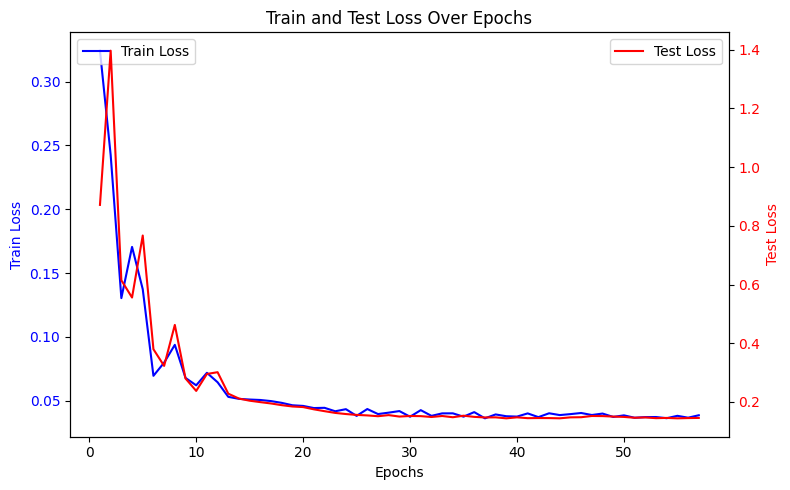

In [ ]:
window_size  = WINDOW_SIZE
forecast_size = FORECAST_HORIZON
idx = resid[resid['Date'] == pd.to_datetime(TEST_DATE)].index[0]
train_df = resid.iloc[:idx]
test_df  = resid.iloc[idx - (forecast_size + window_size):].reset_index(drop=True)

columns_to_use = resid.columns.drop("Date")
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, "Date", columns_to_use)
train_x, train_y, train_date_list = time_slide_df(train_df_fe, window_size, forecast_size, "Date", columns_to_use)
test_x, test_y, test_date_list   = time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)

configs = Namespace(
    seq_len      = window_size,
    pred_len     = forecast_size,
    ker_len      = 25,
    enc_in       = len(columns_to_use),
    patch_len    = 3,
    stride       = 2,
    padding_patch= 'end',
    revin        = True,
    ma_type      = 'ema',
    alpha        = 0.3,
    beta         = 0.3,
    patch_size   = 3,
    patch_stride = 2,
    obs_cov = 1,
    trans_cov = 1,
)
train_ds = Data(train_x, train_y)
test_ds  = Data(test_x, test_y)
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=len(test_df), shuffle=False)

model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
patience   = 20
save_path  = os.path.join(DIR_PATH, f"model{VERSION}.pth")

train_loss_list, test_loss_list = train_deep_learning_model(model, train_dl, test_dl, criterion, optimizer, num_epochs, patience, save_path)
plot_loss_curve(train_loss_list, test_loss_list)

Draw the Results

Seoul_HPI: RMSE=6.913, MAE=5.827000141143799
Busan_HPI: RMSE=3.949, MAE=3.0350000858306885
Daegu_HPI: RMSE=4.193, MAE=2.944000005722046
Incheon_HPI: RMSE=5.278, MAE=4.324999809265137
Gwangju_HPI: RMSE=3.471, MAE=2.7230000495910645
Daejeon_HPI: RMSE=4.166, MAE=3.4670000076293945
Ulsan_HPI: RMSE=3.531, MAE=2.7709999084472656
Sejong_HPI: RMSE=6.787, MAE=5.335999965667725
Gyeonggi_HPI: RMSE=6.004, MAE=5.105000019073486
Gangwon_HPI: RMSE=2.3, MAE=1.815000057220459
Chungbuk_HPI: RMSE=2.162, MAE=1.6380000114440918
Chungnam_HPI: RMSE=2.053, MAE=1.531000018119812
Jeonbuk_HPI: RMSE=2.391, MAE=1.7999999523162842
Jeonnam_HPI: RMSE=1.626, MAE=1.2350000143051147
Gyeongbuk_HPI: RMSE=2.403, MAE=2.010999917984009
Gyeongnam_HPI: RMSE=2.777, MAE=2.359999895095825
Jeju_HPI: RMSE=3.708, MAE=3.0179998874664307


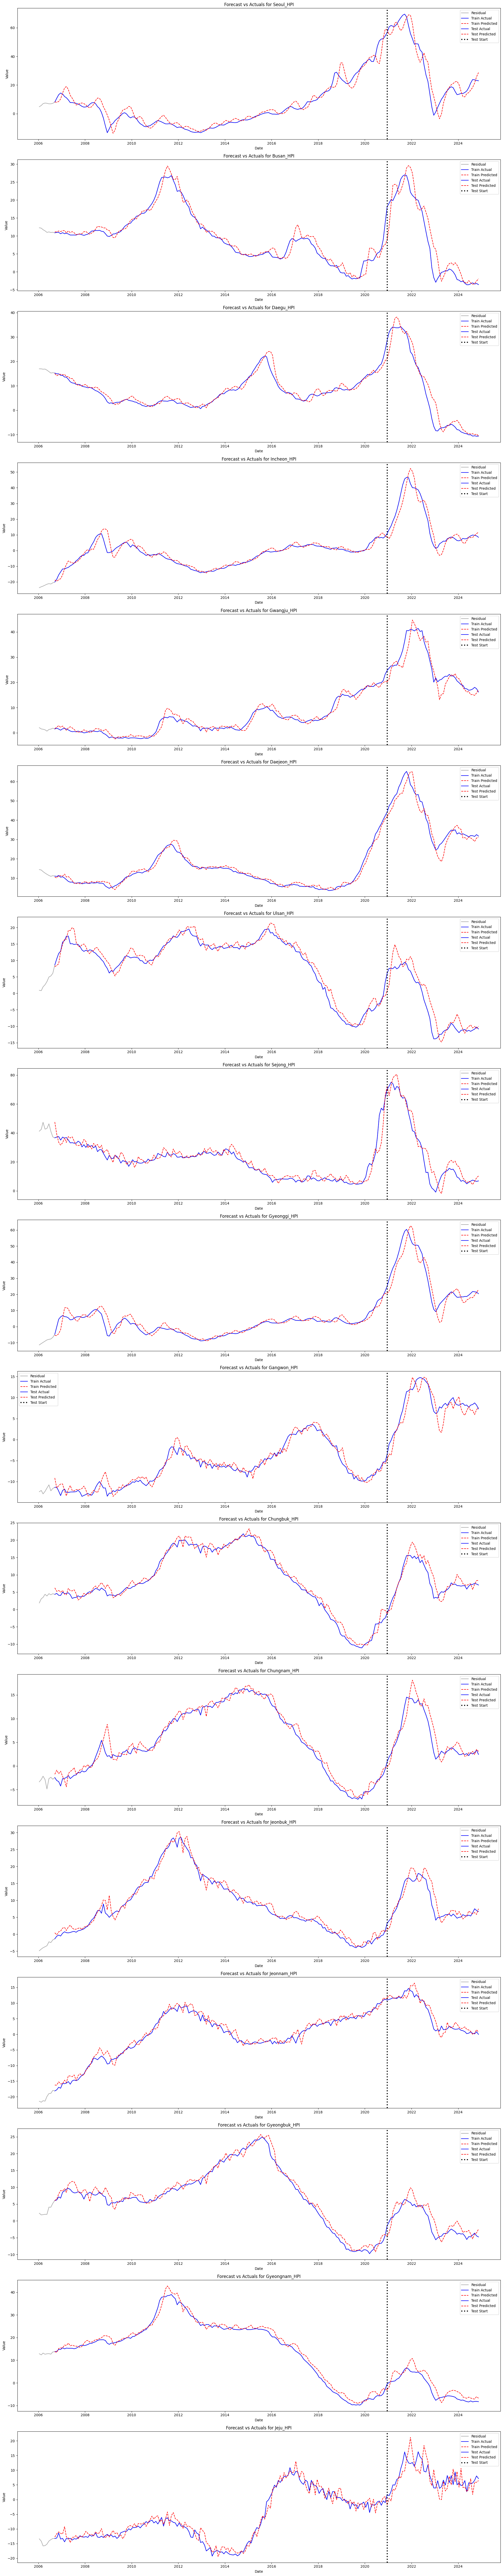

In [13]:
model.load_state_dict(torch.load(save_path))
model.eval()

train_outputs, train_targets = evaluate_model(model, DataLoader(train_ds, batch_size=len(train_ds), shuffle=False))
test_outputs, test_targets   = evaluate_model(model, DataLoader(test_ds, batch_size=len(test_ds), shuffle=False))

train_predicted = train_outputs[:, -1, :].cpu().numpy()
train_actual    = train_targets[:, -1, :].cpu().numpy()
train_dates = train_date_list[:, -1] 

test_predicted  = test_outputs[:, -1, :].cpu().numpy()
test_actual     = test_targets[:, -1, :].cpu().numpy()
test_dates = test_date_list[:, -1] 

plot_deep_learning_results(resid, columns_to_use, train_dates, test_dates,
                           train_actual, train_predicted, test_actual, test_predicted,
                           mean_, std_,
                           DIR_PATH, VERSION)


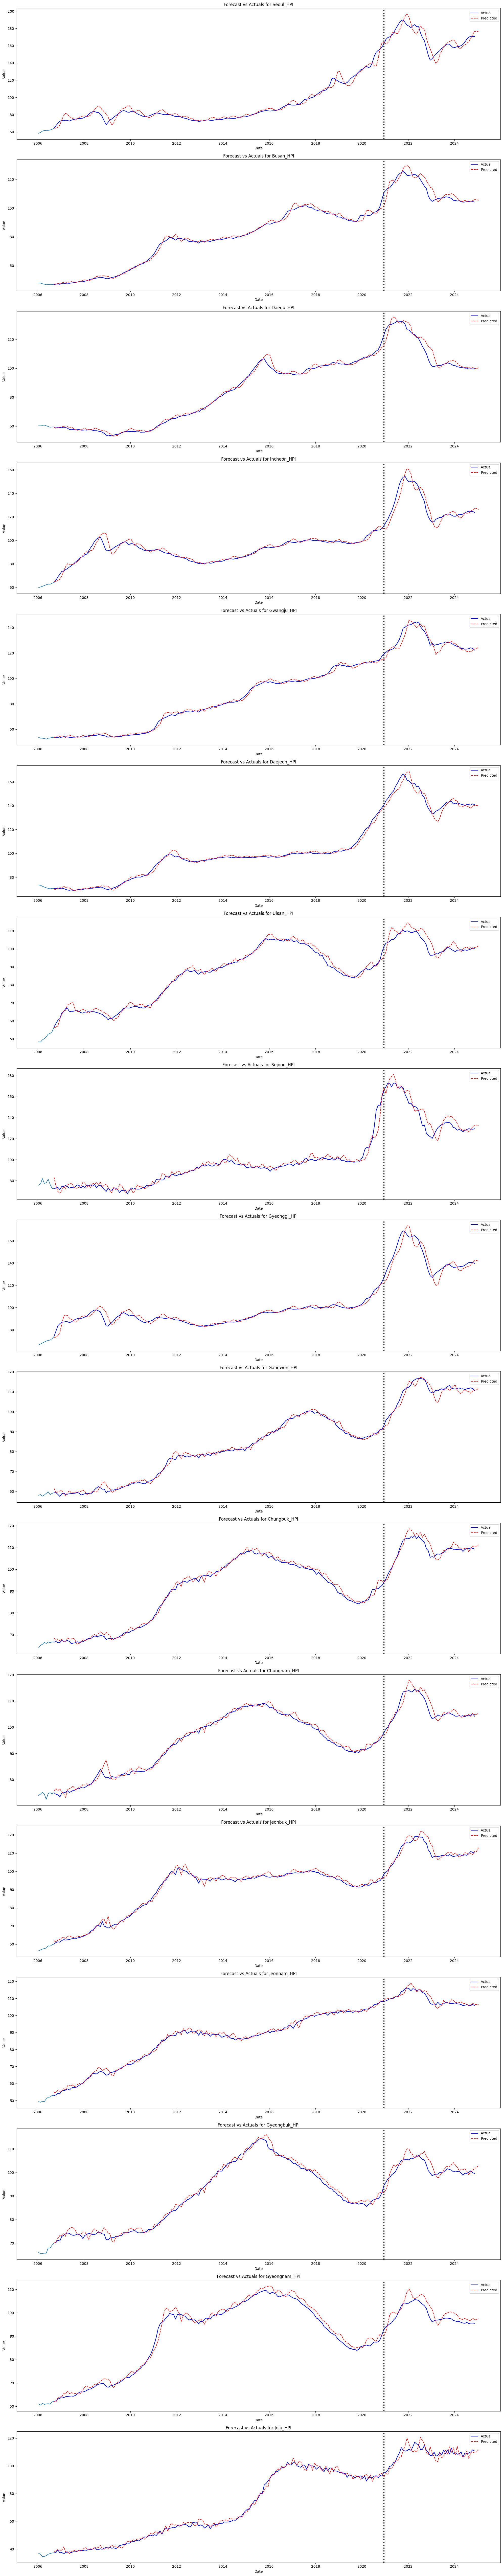

In [14]:
additional_test_x, additional_test_y, additional_test_date = test_time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)
addi_test_ds = Data(additional_test_x, additional_test_y)
addi_test_dl  = DataLoader(addi_test_ds, batch_size=len(additional_test_x), shuffle=False)
with torch.no_grad():
    for data, target in addi_test_dl:
        addi_test_output = model(data)
        addi_test_predicted = addi_test_output[:, -1, :].cpu().numpy() 

f = (pd.concat(smoothed_factors,axis=1).values @ loadings.T) * scale_factor + target_df_train.mean().values + offset
f_pd_all = pd.DataFrame(f, index=pd.to_datetime(smoothed_factors['factor1'].index), columns=target_df.columns)

plot_additional_test_predictions(target_df, columns_to_use,
                                 train_actual, train_predicted,
                                 test_actual, test_predicted,
                                 addi_test_predicted,
                                 train_dates, test_dates,
                                 mean_, std_, f_pd_all, forecast_size)